In [9]:
# Import features and data

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from src.feature_utils import log_transform, ordinal_encode, scale_features
from src.model_utils import get_models
from src.validation_utils import run_kfold
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

df = pd.read_csv("Stars.csv")

In [3]:
# Plot Stylization

plt.style.use("dark_background")

COLORS = {
    "pink": "#ff4ecd",
    "blue": "#4ea8ff",
    "green": "#3dff9f",
    "purple": "#b36bff"
}

In [11]:
# Create a method for bootstrapping

def bootstrap_stars(df, target_col, n_total=1000, random_state=42):
    rng = np.random.default_rng(random_state)
    synthetic = []

    class_counts = df[target_col].value_counts(normalize=True)

    for cls, frac in class_counts.items():
        n_samples = int(frac * n_total)
        subset = df[df[target_col] == cls]

        sampled = subset.sample(
            n=n_samples,
            replace=True,
            random_state=random_state
        ).copy()

        # add mild noise to continuous features
        for col in ["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)"]:
            sampled[col] *= rng.normal(1, 0.03, size=len(sampled))

        synthetic.append(sampled)

    return pd.concat(synthetic, ignore_index=True)


In [13]:
# Apply Bootstrapping

df_bootstrap = bootstrap_stars(
    df,
    target_col="Star type",
    n_total=1000
)

df_bootstrap["Star type"].value_counts()

Star type
0    166
1    166
2    166
3    166
4    166
5    166
Name: count, dtype: int64

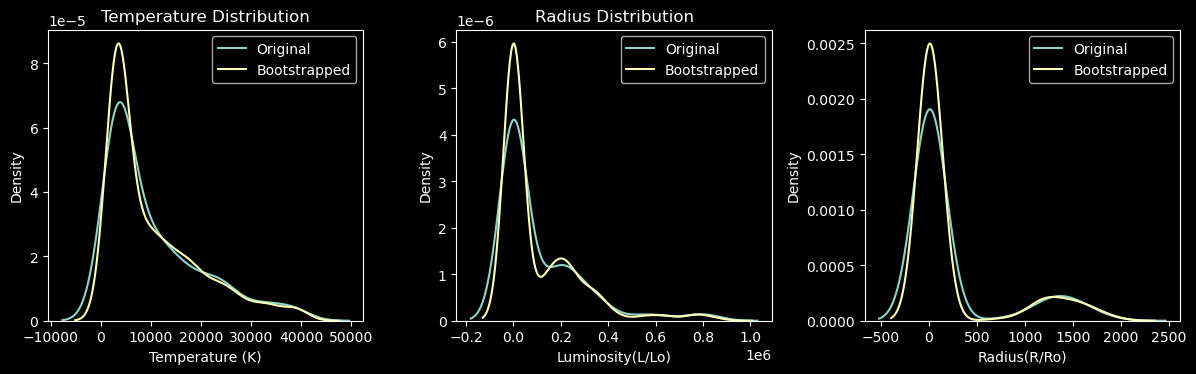

In [27]:
# Distribution Drift Check

plt.style.use("dark_background")

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

sns.kdeplot(df["Temperature (K)"], ax=axes[0], label="Original")
sns.kdeplot(df_bootstrap["Temperature (K)"], ax=axes[0], label="Bootstrapped")
axes[0].set_title("Temperature Distribution")

sns.kdeplot(df["Luminosity(L/Lo)"], ax=axes[1], label="Original")
sns.kdeplot(df_bootstrap["Luminosity(L/Lo)"], ax=axes[1], label="Bootstrapped")
axes[1].set_title("Luminosity Distribution")

sns.kdeplot(df["Radius(R/Ro)"], ax=axes[2], label="Original")
sns.kdeplot(df_bootstrap["Radius(R/Ro)"], ax=axes[2], label="Bootstrapped")
axes[1].set_title("Radius Distribution")

for ax in axes:
    ax.legend()

plt.tight_layout()
plt.show()

In [37]:
# Apply features

df_fe = log_transform(
    df_bootstrap,
    columns=["Temperature (K)", "Luminosity(L/Lo)", "Radius(R/Ro)"]
)

df_fe = ordinal_encode(df_fe)
df_fe.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3.447684,-3.059121,-0.959985,19.45,0,11,6
1,3.441993,-3.042705,-1.120206,19.56,0,11,6
2,3.477277,-3.855914,-0.935115,18.89,0,11,6
3,3.427058,-3.398470,-1.033876,17.40,0,11,6
4,3.495336,-3.375147,-1.048839,17.16,0,11,6


In [39]:
# Splite the Data

X_boot = df_fe.drop("Star type", axis=1)
y_boot = df_fe["Star type"]

boot_results = []

In [41]:
# Instantiate the baseline
models = get_models()

# Evaluate the baseline

results = {}

for name, model in models.items():
    mean_acc, std_acc = run_kfold(
        model=model,
        X=X_boot,
        y=y_boot,
        k=5
    )
    results[name] = (mean_acc, std_acc)
    print(f"{name}: {mean_acc:.3f} ± {std_acc:.3f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

logistic_regression: 1.000 ± 0.000
knn: 1.000 ± 0.000
random_forest: 1.000 ± 0.000
svm: 0.998 ± 0.002


In [43]:
# Table of results above

pd.DataFrame(
    results,
    index=["Mean Accuracy", "Std Dev"]
).T

,Mean Accuracy,Std Dev
logistic_regression,1.00000,0.000000
knn,1.00000,0.000000
random_forest,1.00000,0.000000
svm,0.99799,0.002462


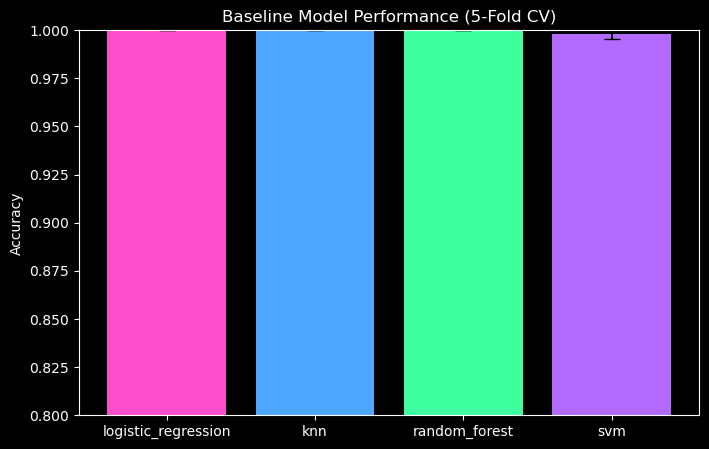

In [47]:
# Mean vs CV

model_names = list(results.keys())
mean_acc = [results[m][0] for m in model_names]
std_acc = [results[m][1] for m in model_names]

plt.figure(figsize=(8, 5))
plt.bar(
    model_names,
    mean_acc,
    yerr=std_acc,
    capsize=6,
    color=[COLORS["pink"], COLORS["blue"], COLORS["green"], COLORS["purple"]]
)

plt.ylabel("Accuracy")
plt.title("Baseline Model Performance (5-Fold CV)")
plt.ylim(0.8, 1.0)
plt.show()

In [49]:
# Create cross validation folds

plt.style.use("dark_background")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
cv_predictions = {}
cv_probabilities = {}

In [57]:
# Clearly seperate the sets

for name, model in models.items():

    y_pred = cross_val_predict(
        model,
        X_boot,
        y_boot,
        cv=cv,
        method="predict"
    )

    y_prob = cross_val_predict(
        model,
        X_boot,
        y_boot,
        cv=cv,
        method="predict_proba"
    )

    cv_predictions[name] = y_pred
    cv_probabilities[name] = y_prob

    results.append({
        "model": name,
        "accuracy": accuracy_score(y_boot, y_pred),
        "roc_auc": roc_auc_score(
            y_boot,
            y_prob,
            multi_class="ovr"
        )
    })

df_results = pd.DataFrame(results)
df_results

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

,model,accuracy,roc_auc
0,logistic_regression,0.997992,0.999985
1,knn,1.000000,1.000000
2,random_forest,1.000000,1.000000
3,svm,0.994980,1.000000


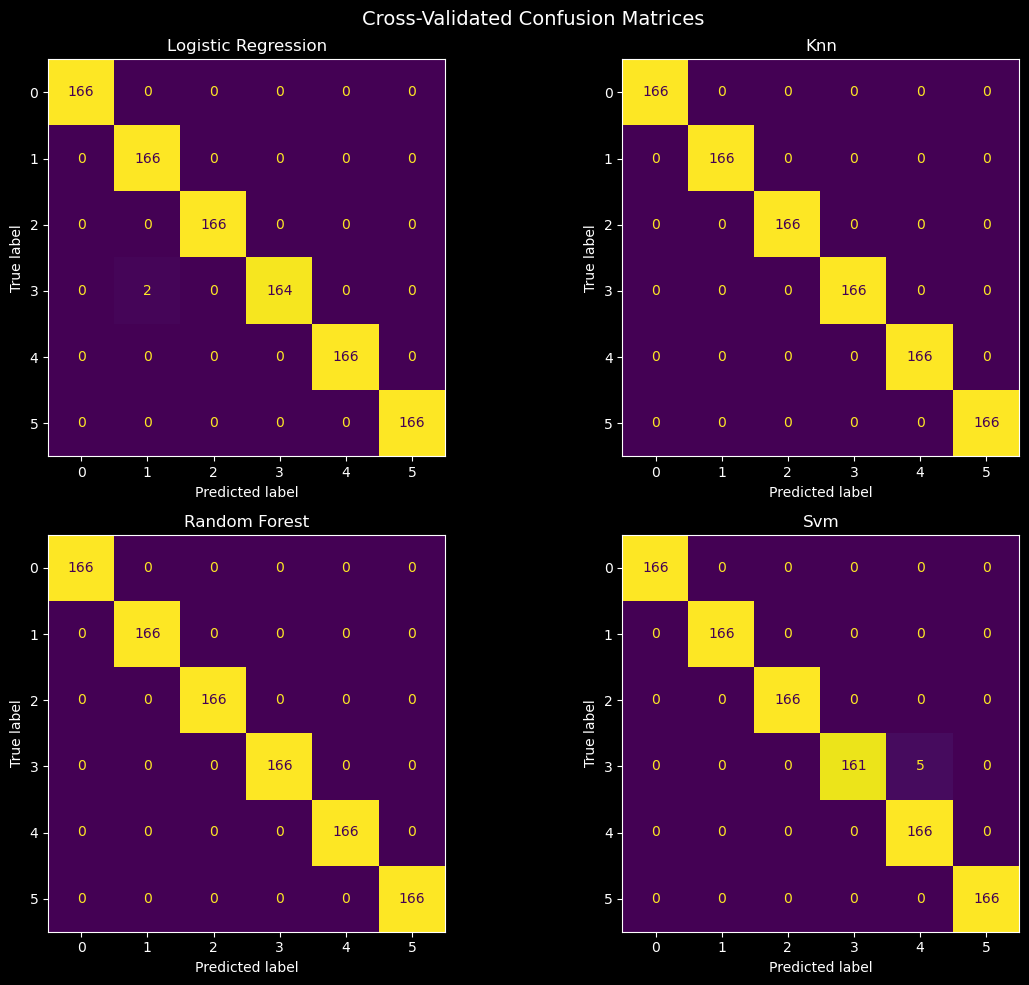

In [61]:
# Confustion Matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, cv_predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y_boot,
        y_pred,
        ax=ax,
        colorbar=False
    )
    ax.set_title(name.replace("_", " ").title())

plt.suptitle("Cross-Validated Confusion Matrices", fontsize=14)
plt.tight_layout()
plt.show()

In [71]:
# God help me, I'm going mad at how perfect these models are!
# Create a noise pattern

def add_noise(df, noise_config, random_state=42):
    rng = np.random.default_rng(random_state)
    df_noisy = df.copy()

    for col, noise_pct in noise_config.items():
        noise = rng.normal(
            loc=0,
            scale=noise_pct,
            size=len(df)
        )
        df_noisy[col] *= (1 + noise)

    return df_noisy

In [73]:
# Apply the noise

noise_config = {
    "Temperature (K)": 0.02,
    "Luminosity(L/Lo)": 0.05,
    "Radius(R/Ro)": 0.05
}

df_noisy = add_noise(df_fe, noise_config)

In [75]:
# Look if noise has been properly applied

df_noisy.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3.468696,-3.176411,-0.971105,19.45,0,11,6
1,3.370400,-3.061140,-1.174265,19.56,0,11,6
2,3.529468,-3.881125,-0.939223,18.89,0,11,6
3,3.491526,-3.538445,-1.054140,17.40,0,11,6
4,3.358946,-3.365142,-1.064772,17.16,0,11,6


In [77]:
# Seperate Features from the Target

X = df_noisy.drop("Star type", axis=1)
y = df_noisy["Star type"]

X_scaled, scaler = scale_features(X)

In [79]:
# Instantiate the baseline
models = get_models()

# Evaluate the baseline

results = {}

for name, model in models.items():
    mean_acc, std_acc = run_kfold(
        model=model,
        X=X_scaled,
        y=y,
        k=5
    )
    results[name] = (mean_acc, std_acc)
    print(f"{name}: {mean_acc:.3f} ± {std_acc:.3f}")

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

logistic_regression: 0.986 ± 0.009
knn: 0.997 ± 0.002
random_forest: 1.000 ± 0.000
svm: 0.990 ± 0.007


In [81]:
# Table of results above

pd.DataFrame(
    results,
    index=["Mean Accuracy", "Std Dev"]
).T

,Mean Accuracy,Std Dev
logistic_regression,0.985950,0.008632
knn,0.996990,0.002458
random_forest,1.000000,0.000000
svm,0.989965,0.007096


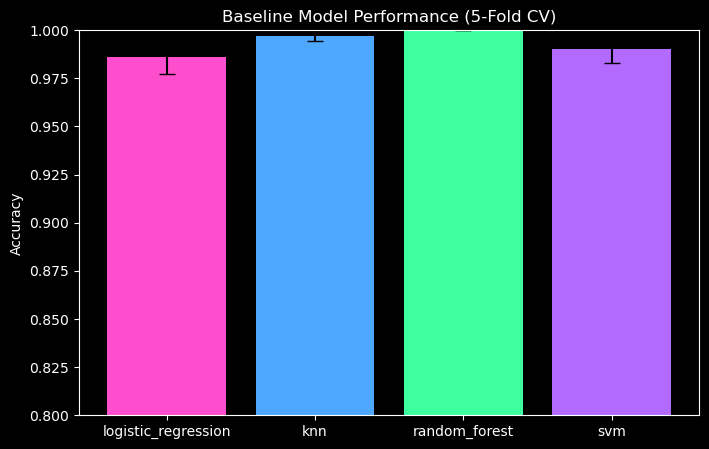

In [83]:
# Mean vs CV

model_names = list(results.keys())
mean_acc = [results[m][0] for m in model_names]
std_acc = [results[m][1] for m in model_names]

plt.figure(figsize=(8, 5))
plt.bar(
    model_names,
    mean_acc,
    yerr=std_acc,
    capsize=6,
    color=[COLORS["pink"], COLORS["blue"], COLORS["green"], COLORS["purple"]]
)

plt.ylabel("Accuracy")
plt.title("Baseline Model Performance (5-Fold CV)")
plt.ylim(0.8, 1.0)
plt.show()

In [85]:
# Create cross validation folds

plt.style.use("dark_background")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []
cv_predictions = {}
cv_probabilities = {}

In [87]:
# Clearly seperate the sets

for name, model in models.items():

    y_pred = cross_val_predict(
        model,
        X,
        y,
        cv=cv,
        method="predict"
    )

    y_prob = cross_val_predict(
        model,
        X,
        y,
        cv=cv,
        method="predict_proba"
    )

    cv_predictions[name] = y_pred
    cv_probabilities[name] = y_prob

    results.append({
        "model": name,
        "accuracy": accuracy_score(y, y_pred),
        "roc_auc": roc_auc_score(
            y,
            y_prob,
            multi_class="ovr"
        )
    })

df_results = pd.DataFrame(results)
df_results

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in versio

,model,accuracy,roc_auc
0,logistic_regression,0.997992,0.999981
1,knn,1.000000,1.000000
2,random_forest,1.000000,1.000000
3,svm,0.994980,1.000000


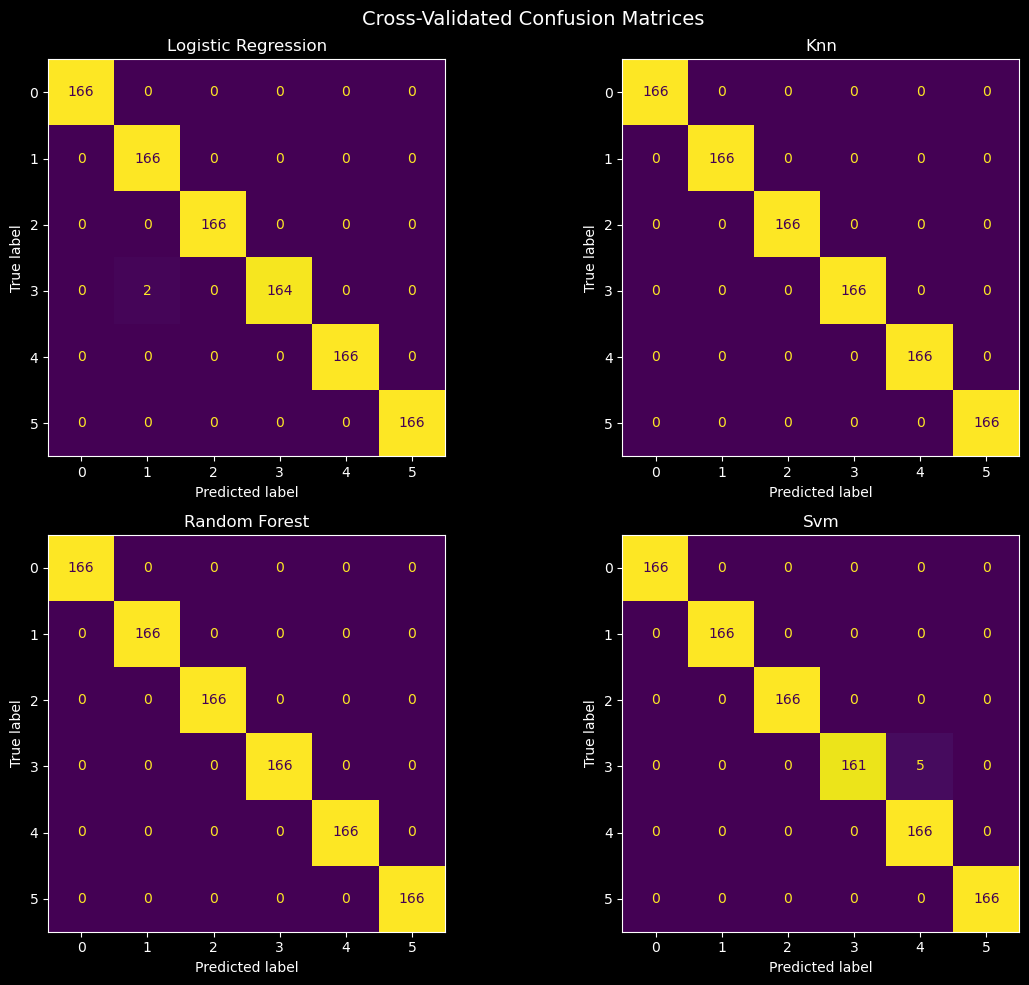

In [89]:
# Confustion Matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, cv_predictions.items()):
    ConfusionMatrixDisplay.from_predictions(
        y,
        y_pred,
        ax=ax,
        colorbar=False
    )
    ax.set_title(name.replace("_", " ").title())

plt.suptitle("Cross-Validated Confusion Matrices", fontsize=14)
plt.tight_layout()
plt.show()